# WireScanner before/after Deconvolution

In this notebook we compare the WS measurements for an **LHC25-type beam** with the default parameters and application used in 2016 and the proposed changes in 2017, i.e. measured dispersion and full deconvolution assuming the profile Gaussian for the betatronic component.

Input needed:
* WS output file from FESA class
* Tomogram for each measurement (so far acquired with an independent application and synchronized by hand)


In [2]:
import sys
sys.path.append('/eos/user/s/sterbini/MD_ANALYSIS/public/')
#you can add it in a the a configuration script to run at the start of SWAN e.g.:
# export PYTHONPATH="$PYTHONPATH:/eos/user/s/sterbini/MD_ANALYSIS/public"
from myToolbox import *

Version 0.03. This is the latest version.
Please help me to improve it reporting bugs to guido.sterbini@cern.ch.
Your platform is Linux-3.10.0-514.2.2.el7.x86_64-x86_64-with-redhat-6.7-Carbon
Your folder is /eos/user/d/digiovan/2016/MD74
Your IP is 172.17.0.16
2017-02-08 16:58:58


In [3]:
# useful defintion
ring  = '3'
plane = 'H'

folder_data = 'PSB_r' + ring + '_p' + plane
print folder_data

folder_tomo = 'PSB_r' + ring + '_tomograms_' + plane
print folder_tomo

modelBetaOptics_m=5.699084 # m (MODEL horizontal plane)
modelDispersion_m=1.465799 # m (MODEL horizontal plane)

# default from ring 3/H
measuDispersion_m=1.3634   # m (MEASURED horizontal plane)

if ring == '1':
    measuDispersion_m = 1.3619
if ring == '2':
    measuDispersion_m = 1.3884
if ring == '4':    
    measuDispersion_m = 1.3827

print 'measured dispersion = ', measuDispersion_m

PSB_r3_pH
PSB_r3_tomograms_H
measured dispersion =  1.3634


In [4]:
def extractProfile(fileName):
    '''Give me the input file (.dat) of the tomogram and I will give you 2 output:
        the deltaP_P and the the momentum distribution profile.
    ''' 

    print '/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName
    a=os.system('/eos/project/l/liu/Instrumentation/tomography/runofflinetomo ' + fileName)
    
    convergence=np.loadtxt('./' + fileName[0:-4] + '/d001.data')
    image=np.loadtxt('./' + fileName[0:-4] + '/image001.data')
    with open('./' + fileName[0:-4] + '/input_v2.dat','r') as stream: tomofileheader = stream.readlines()[:98]

    myInput={'PLSUSER': tomofileheader[0][0:-1],
            'NumberOfframes': np.int(tomofileheader[16][0:-1]),
            'B_T': np.double(tomofileheader[75][0:-1]),
            'Bdot_T_per_s': np.double(tomofileheader[77][0:-1]),
            'machineRadius_m': np.double(tomofileheader[79][0:-1]),
            'bendingRadius_m': np.double(tomofileheader[81][0:-1]),
            'particleMass_eV': np.double(tomofileheader[85][0:-1]),
            'h': np.int(np.double(tomofileheader[69][0:-1])),
            'ctime': np.int(tomofileheader[2])
    }

    with open('./' + fileName[0:-4] + '/plotinfo.data','r') as stream: tomofileheader = stream.readlines()

    myInput['profilecount']=np.int(str.split(tomofileheader[1])[2])
    myInput['profilelength']=np.int(str.split(tomofileheader[3])[2])

    myInput['dtbin']=np.double(str.split(tomofileheader[5])[2])
    myInput['dEbin']=np.double(str.split(tomofileheader[7])[2])
    myInput['xat0']=np.double(str.split(tomofileheader[11])[2])
    myInput['yat0']=np.double(str.split(tomofileheader[12])[2])
    myInput['eperimage']=np.double(str.split(tomofileheader[9])[2])

    mySpeedOfLight=299792458. #TODO
    myInput['momentum_eV']=myInput['B_T']*myInput['bendingRadius_m']/(10/mySpeedOfLight*1e8)*1.e9 #TODO
    myInput['totalEnergy_eV']=np.sqrt(myInput['momentum_eV']**2+myInput['particleMass_eV']**2)
    myInput['gamma']=myInput['totalEnergy_eV']/myInput['particleMass_eV']
    myInput['beta']=np.sqrt(1-1/myInput['gamma']**2)

    image=image*myInput['eperimage']/myInput['dtbin']/myInput['dEbin']

    halfProfileLength=myInput['profilelength']/2.

    Toffset= (myInput['xat0']-halfProfileLength)*myInput['dtbin']*1e9
    Eoffset= (myInput['yat0']-halfProfileLength)*myInput['dEbin']/1e6

    t=np.arange(-halfProfileLength,halfProfileLength)*myInput['dtbin']*1e9-Toffset
    E=np.arange(-halfProfileLength,halfProfileLength)*myInput['dEbin']/1e6-Eoffset


    deltaP_P= 1/myInput['beta']**2*E*1e6/myInput['totalEnergy_eV']
    myProfile=np.sum(np.reshape(image, [myInput['profilelength'], myInput['profilelength']]),0)
    myProfile=myProfile/np.trapz(myProfile,deltaP_P)
    myInput['deltaP_P']=deltaP_P;
    myInput['myProfile']=myProfile;
    myInput['E_MeV']=E
    myInput['t_ns']=t
    myInput['phaseSpace_e_per_eVs']=np.reshape(image, [myInput['profilelength'], myInput['profilelength']]);
    myProfileNormalized=myProfile/np.trapz(myProfile,deltaP_P)
    myMean=np.trapz(deltaP_P*myProfileNormalized,deltaP_P)
    myRMS=np.sqrt(np.trapz((deltaP_P-myMean)**2*myProfileNormalized,deltaP_P))
    myInput['deltaP_P_RMS']=myRMS
    return myInput

In [5]:
# Get the list of files from the WS
matfiles=sorted(glob.glob('/eos/user/d/digiovan/2016/MD74/data/ws_sem/' + folder_data +'/*mat'))
print len(matfiles)
#print matfiles[0]
#print matfiles

40


In [6]:
# my test for checking the variables stored
#myExample=myToolbox.japcMatlabImport(matfiles[9])

# write "myExample." and then press "Tab" to check which variable is stored
#myExample.BR3_BWS_2L1_H_ROT.Logging.value.projPositionSet1
#myExample.BR3_BWS_2L1_H_ROT.Logging.value.projDataSet1
#myExample.BR_BCTDC.Acquisition.value.extIntensityRing2


In [7]:
# convert to dataFrame
myDataFrame=myToolbox.fromMatlabToDataFrame(matfiles,['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projPositionSet1',
                                                      'BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projDataSet1',
                                                      'BR_BCTDC.Acquisition.value.extIntensityRing'+ring]);

# Uncomment to check if the data are properly loaded
#myDataFrame['BR'+ring+'_BWS_2L1_'+plane+'H_ROT.Logging.value.projPositionSet1']
#myDataFrame['BR_BCTDC.Acquisition.value.extIntensityRing'+ring]

In [8]:
# Add a list of tomofiles
tomoFilePath = []

tomofiles = sorted(glob.glob('data/ws_sem/'+ folder_tomo + '/*dat'))

if len(tomofiles) != len(matfiles):
    print "Mismatch: the lenghts of files and tomograms is NOT the same"
else:
    print "1-to-1 Matching"
    for i in tomofiles:
        # uncomment in case you want to have a look at the files
        #print(i)
        tomoFilePath.append(i)
    
    # add the tomograms to the DataFrame... assuming 1-to-1 correspondence (no matching with timestamp...)
    myDataFrame['tomoFilePath'] = pnd.Series(tomoFilePath, index=myDataFrame.index)
    
#myDataFrame['tomoFilePath'].values

1-to-1 Matching


In [9]:
# calculate the Dp/p profile and add it to the DataFrame
myDataFrame['momentumProfile']=myDataFrame['tomoFilePath'].apply(extractProfile)

/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r3_tomograms_H/R3ejref_New_2016_001.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r3_tomograms_H/R3ejref_New_2016_002.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r3_tomograms_H/R3ejref_New_2016_003.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r3_tomograms_H/R3ejref_New_2016_004.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r3_tomograms_H/R3ejref_New_2016_005.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r3_tomograms_H/R3ejref_New_2016_006.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r3_tomograms_H/R3ejref_New_2016_007.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo data/ws_sem/PSB_r3_tomograms_H/R3ejref_New_2016_008.dat
/eos/project/l/liu/Instrumentation/tomography/runofflinetomo dat

[ 1.61995191]
2.53844989231
0.00115955805533
1.41442058787


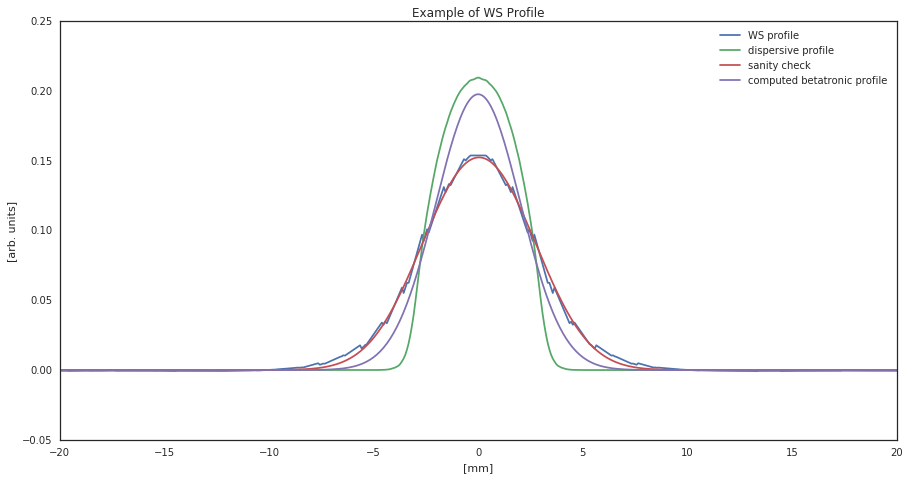

In [18]:
sns.set_style("white")

# test with the first profile
i=12
                                                   
out=myToolbox.computeTransverseEmittance(myDataFrame.iloc[i]['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projPositionSet1'],
                                         myDataFrame.iloc[i]['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projDataSet1'],
                                         myDataFrame.iloc[i]['momentumProfile']['myProfile'],
                                         myDataFrame.iloc[i]['momentumProfile']['deltaP_P'],
                                         myDataFrame.iloc[i]['momentumProfile']['beta']*myDataFrame.iloc[i]['momentumProfile']['gamma'],
                                         betaOptical_m=modelBetaOptics_m,Dispersion_m=measuDispersion_m)

plt.plot(out['WS_position_mm'],out['WS_profile'],label='WS profile')
plt.hold('on')
plt.plot(out['Dispersive_position_mm'],out['Dispersive_profile'],label='dispersive profile')
plt.hold('off')
plt.xlabel('[mm]')
plt.ylabel('[arb. units]')
plt.plot(out['WS_position_mm'],out['convolutionBackComputed'],label='sanity check')
plt.plot(out['WS_position_mm'],out['betatronicProfile'],label='computed betatronic profile')
plt.legend()
plt.xlim([-20,20])
print(out['emittance_um'])
#str(myDataFrame.iloc[i]['momentumProfile']['gamma']) +' '+ str(myDataFrame.iloc[i]['momentumProfile']['ctime']))
plt.title('Example of WS Profile')

a,b=myToolbox.makeGaussianFit_5_parameters(myDataFrame.iloc[i]['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projPositionSet1'],
                                           myDataFrame.iloc[i]['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projDataSet1'])
sigma=a[4]/1000
print(sigma)
print(myDataFrame.iloc[i]['momentumProfile']['deltaP_P_RMS'])
print (sigma**2-(myDataFrame.iloc[i]['momentumProfile']['deltaP_P_RMS']*modelDispersion_m*1000)**2)/modelBetaOptics_m*myDataFrame.iloc[i]['momentumProfile']['beta']*myDataFrame.iloc[i]['momentumProfile']['gamma']

1.41442058802


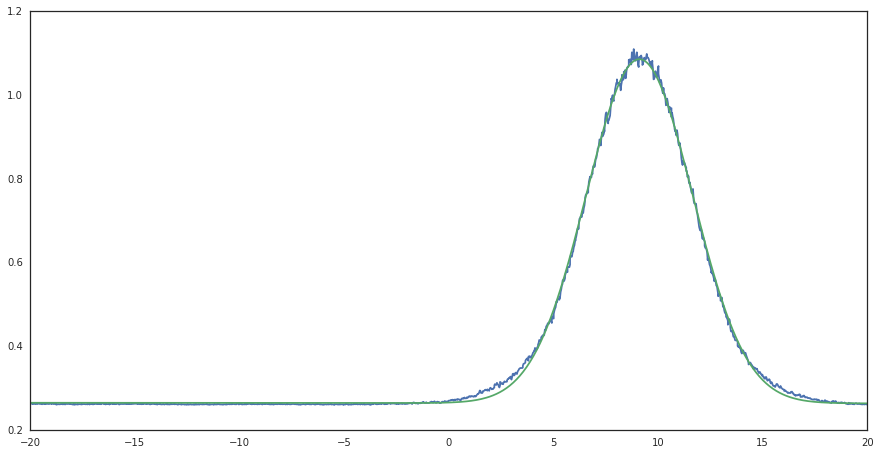

In [24]:
# test with the first profile
i=12
                                                   
out=myToolbox.computeTransverseEmittance(myDataFrame.iloc[i]['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projPositionSet1'],
                                         myDataFrame.iloc[i]['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projDataSet1'],
                                         myDataFrame.iloc[i]['momentumProfile']['myProfile'],
                                         myDataFrame.iloc[i]['momentumProfile']['deltaP_P'],
                                         myDataFrame.iloc[i]['momentumProfile']['beta']*myDataFrame.iloc[i]['momentumProfile']['gamma'],
                                         betaOptical_m=modelBetaOptics_m,Dispersion_m=measuDispersion_m)

a,b=myToolbox.makeGaussianFit_5_parameters(myDataFrame.iloc[i]['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projPositionSet1']/1000.,
                                           myDataFrame.iloc[i]['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projDataSet1'])


plt.plot(myDataFrame.iloc[i]['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projPositionSet1']/1000.,
         myDataFrame.iloc[i]['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projDataSet1'])

plt.hold('on')
xfine = np.linspace(-40, 40., 1000)  # define values to plot the function for
plt.plot(xfine, myToolbox.gaussian_5_parameters(xfine, a[0],a[1],a[2],a[3],a[4]))

plt.xlim([-20,20])

plt.hold('off')

sigma = a[4]
print (sigma**2-(myDataFrame.iloc[i]['momentumProfile']['deltaP_P_RMS']*modelDispersion_m*1000)**2)/modelBetaOptics_m*myDataFrame.iloc[i]['momentumProfile']['beta']*myDataFrame.iloc[i]['momentumProfile']['gamma']


In [13]:
def simpleMethod(myDataFrame):
    a,b=myToolbox.makeGaussianFit_5_parameters(myDataFrame['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projPositionSet1'],
                                               myDataFrame['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projDataSet1'])
    
    sigma=a[4]/1000
    return ((sigma**2-(myDataFrame['momentumProfile']['deltaP_P_RMS']*modelDispersion_m*1000)**2)/
            modelBetaOptics_m*myDataFrame['momentumProfile']['beta']*myDataFrame['momentumProfile']['gamma'])



def simpleMethodMeasDisp(myDataFrame):
    a,b=myToolbox.makeGaussianFit_5_parameters(myDataFrame['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projPositionSet1'],
                                               myDataFrame['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projDataSet1'])
    
    sigma=a[4]/1000
    return ((sigma**2-(myDataFrame['momentumProfile']['deltaP_P_RMS']*measuDispersion_m*1000)**2)/
            modelBetaOptics_m*myDataFrame['momentumProfile']['beta']*myDataFrame['momentumProfile']['gamma'])



def fullPower(myDataFrame):
                                                      
    out=myToolbox.computeTransverseEmittance(myDataFrame['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projPositionSet1'],
                                             myDataFrame['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projDataSet1'],
                                             myDataFrame['momentumProfile']['myProfile'],
                                             myDataFrame['momentumProfile']['deltaP_P'],
                                             myDataFrame['momentumProfile']['beta']*myDataFrame['momentumProfile']['gamma'],
                                             betaOptical_m=modelBetaOptics_m,Dispersion_m=modelDispersion_m)

    return out['emittance_um'][0]#,out['sigma_mm']

myDataFrame['emittance_um']      = myDataFrame.apply(fullPower,            axis=1)
myDataFrame['emittance_um_disp'] = myDataFrame.apply(simpleMethodMeasDisp, axis=1)            
myDataFrame['emittance_um_old']  = myDataFrame.apply(simpleMethod,         axis=1)            



In [14]:
myDataFrame.iloc[0]

cycleStamp                                                                                 1.4793e+18
matlabPLS                                                                                PSB.USER.MD3
matlabFilePath                                      /eos/user/d/digiovan/2016/MD74/data/ws_sem/PSB...
BR3_BWS_2L1_H_ROT.Logging.value.projDataSet1        [0.265917266049, 0.265917266049, 0.26591726604...
BR_BCTDC.Acquisition.value.extIntensityRing3                                                   156.43
BR3_BWS_2L1_H_ROT.Logging.value.projPositionSet1    [-50001, -50001, -50001, -50001, -50001, -5000...
tomoFilePath                                        data/ws_sem/PSB_r3_tomograms_H/R3ejref_New_201...
momentumProfile                                     {u'Bdot_T_per_s': 0.00250000000007, u'PLSUSER'...
emittance_um                                                                                  1.68909
emittance_um_disp                                                                 

In [15]:
#myDataFrame['emittance_um']
myDataFrame.loc[:,['BR_BCTDC.Acquisition.value.extIntensityRing'+ring,'emittance_um_old','emittance_um_disp','emittance_um']]



,BR_BCTDC.Acquisition.value.extIntensityRing3,emittance_um_old,emittance_um_disp,emittance_um
2016-11-16 14:00:42.065,156.430084,1.575427,1.732652,1.689089
2016-11-16 14:01:00.065,157.187836,1.675750,1.831609,1.704483
2016-11-16 14:01:50.465,166.754562,1.604096,1.760146,1.629008
2016-11-16 14:02:08.465,155.328964,1.590790,1.746466,1.687727
2016-11-16 14:02:58.865,156.962875,1.515309,1.671855,1.602092
2016-11-16 14:03:16.865,160.431992,1.583990,1.746218,1.670597
2016-11-16 14:04:07.265,155.814392,1.506643,1.661785,1.609569
2016-11-16 14:04:25.265,160.467514,1.557981,1.717591,1.622629
2016-11-16 14:05:15.665,156.323517,1.520373,1.676198,1.589658
2016-11-16 14:05:33.665,163.818237,1.584738,1.742837,1.597426


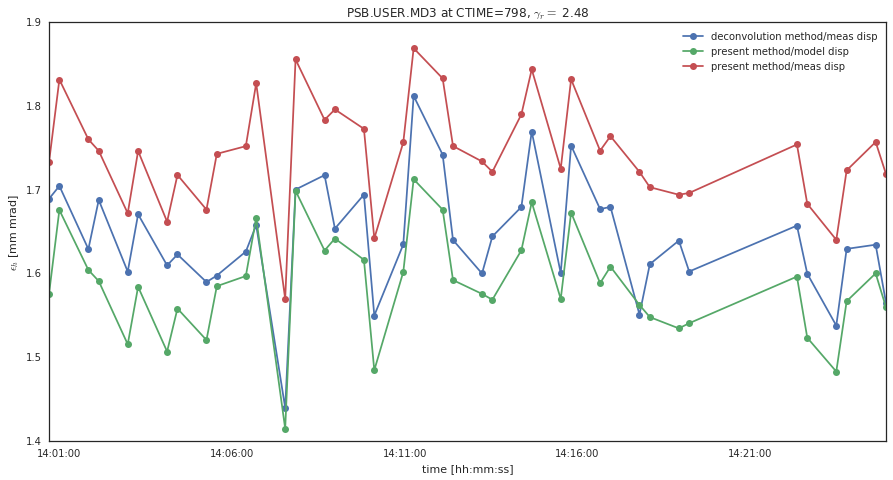

In [91]:
import matplotlib.dates as md
ax=plt.gca()
xfmt = md.DateFormatter('%H:%M:%S')
ax.xaxis.set_major_formatter(xfmt)

plt.plot(myDataFrame['emittance_um'],'o-',label='deconvolution method/meas disp')
plt.hold('on')
plt.plot(myDataFrame['emittance_um_old'],'o-',label='present method/model disp')
plt.legend()
plt.plot(myDataFrame['emittance_um_disp'],'o-',label='present method/meas disp')
plt.legend()

#i=0
plt.title(myDataFrame.iloc[i]['matlabPLS'] + ' at CTIME='+ str(myDataFrame.iloc[i]['momentumProfile']['ctime']) + ', $\gamma_r=$ ' + str(round(myDataFrame.iloc[i]['momentumProfile']['gamma'],2)))
#plt.title(myDataFrame.iloc[i]['matlabPLS'] + ' at CTIME=798' + ', $\gamma_r=$ ' + str(round(myDataFrame.iloc[i]['momentumProfile']['gamma'],2)))
plt.ylabel('$\epsilon_h$ [mm mrad]')
plt.xlabel('time [hh:mm:ss]')
#plt.savefig('/eos/user/d/digiovan/2016/MD74_LHC25_SEMGRID/WireScanner/example_WS3H.pdf')

1.64241383275 +/- 0.0677997423727
1.5862912867 +/- 0.062661537674
1.74357668071 +/- 0.0629589964378


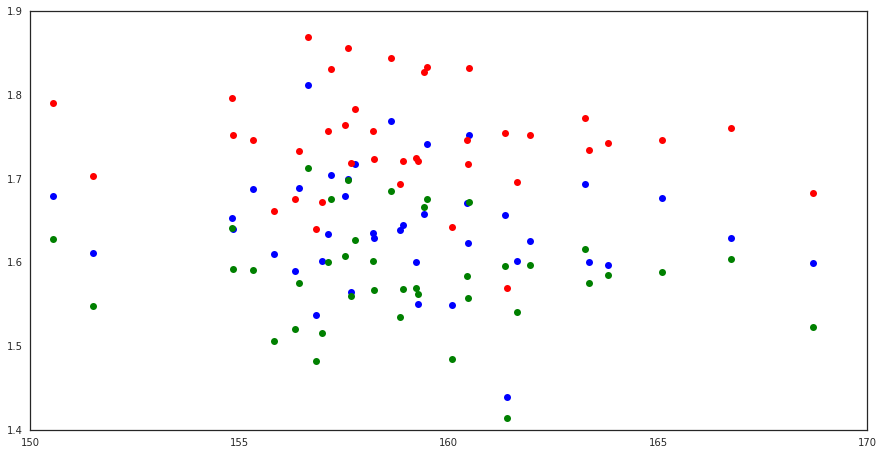

In [17]:
#plt.plot(myDataFrame['emittance_um'],label='deconvolution method/meas disp')
emitt      = myDataFrame['emittance_um'].values
emitt_old  = myDataFrame['emittance_um_old'].values
emitt_disp = myDataFrame['emittance_um_disp'].values

intensity = myDataFrame['BR_BCTDC.Acquisition.value.extIntensityRing'+ring].values

plt.plot(intensity,emitt,'bo')
plt.hold('on')
plt.plot(intensity,emitt_old, 'go')
plt.plot(intensity,emitt_disp,'ro')

import numpy

print numpy.mean(emitt), "+/-", numpy.std(emitt)
print numpy.mean(emitt_old), "+/-", numpy.std(emitt_old)
print numpy.mean(emitt_disp), "+/-", numpy.std(emitt_disp)
         

28
(0.0, 1.717817293989556)
1.99225578929
29
(0.0, 1.705352901926576)
1.97729276227
30
(0.0, 1.7216489421115992)
1.99635770833
31
(0.0, 1.7009716230315828)
1.97924329318


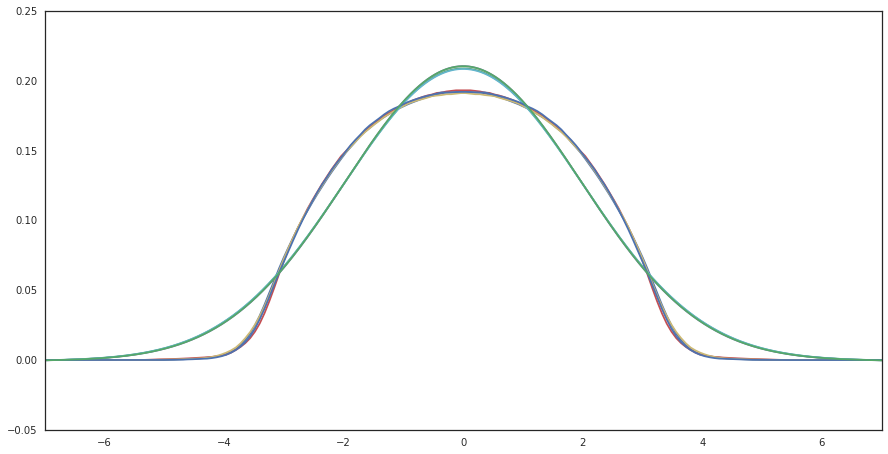

In [55]:
# Attempt to check the different Dp/p distributions

def weighted_avg_and_std(values, weights):
    """
    Return the weighted average and standard deviation.

    values, weights -- Numpy ndarrays with the same shape.
    """
    average = numpy.average(values, weights=weights)
    variance = numpy.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return (average, math.sqrt(variance))


def fullDeconvolution(myDataFrame):
                                                      
    out=myToolbox.computeTransverseEmittance(myDataFrame['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projPositionSet1'],
                                             myDataFrame['BR'+ring+'_BWS_2L1_'+plane+'_ROT.Logging.value.projDataSet1'],
                                             myDataFrame['momentumProfile']['myProfile'],
                                             myDataFrame['momentumProfile']['deltaP_P'],
                                             myDataFrame['momentumProfile']['beta']*myDataFrame['momentumProfile']['gamma'],
                                             betaOptical_m=modelBetaOptics_m,Dispersion_m=modelDispersion_m)

    return out

myDataFrame['deconv_out'] = myDataFrame.apply(fullDeconvolution, axis=1)
#myDataFrame.iloc[0]


#i=0
#deconv_out = myDataFrame.iloc[i]['deconv_out']
#plt.plot(deconv_out['Dispersive_position_mm'],deconv_out['Dispersive_profile'],label='dispersive profile')

for i in range(28,32):
    print i
    deconv_out = myDataFrame.iloc[i]['deconv_out']
    plt.plot(deconv_out['Dispersive_position_mm'],deconv_out['Dispersive_profile'],label='dispersive profile')
    plt.hold('on')
    plt.xlim([-7,7])
    print weighted_avg_and_std(deconv_out['Dispersive_position_mm'],deconv_out['Dispersive_profile'])
    
    a,b=myToolbox.makeGaussianFit_5_parameters(deconv_out['Dispersive_position_mm'],deconv_out['Dispersive_profile'])

    xfine = np.linspace(-7., 7., 1000)  # define values to plot the function for
    plt.plot(xfine, myToolbox.gaussian_5_parameters(xfine, a[0],a[1],a[2],a[3],a[4]))

    print a[4]


1.03551482422 +/- 0.0208149754284
1.09930251176 +/- 0.00401164703324


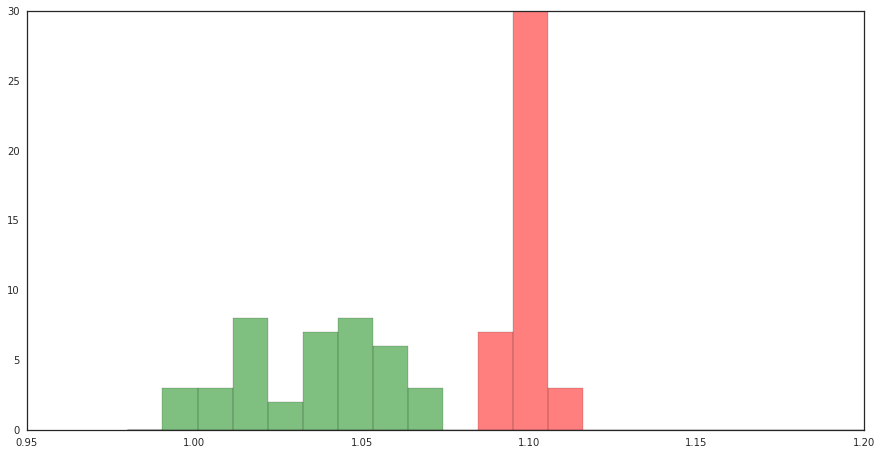

In [73]:
bins = numpy.linspace(0.98, 1.20, 22)

ratio_um      = myDataFrame['emittance_um'].values     /myDataFrame['emittance_um_old'].values
ratio_um_disp = myDataFrame['emittance_um_disp'].values/myDataFrame['emittance_um_old'].values

plt.hist( ratio_um,      bins, facecolor='green', alpha=0.5) 
plt.hist( ratio_um_disp, bins, facecolor='red'  , alpha=0.5) 

print numpy.mean(ratio_um),      "+/-", numpy.std(ratio_um)
print numpy.mean(ratio_um_disp), "+/-", numpy.std(ratio_um_disp)

         

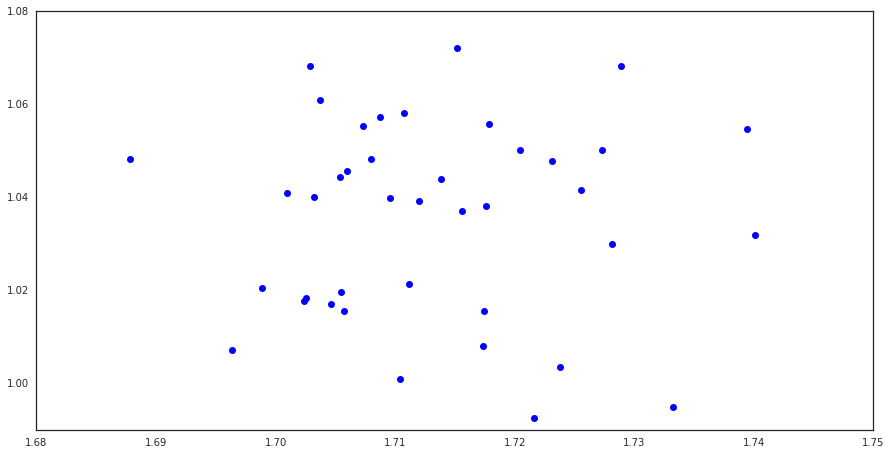

In [90]:
w_results = []

for i in range(len(myDataFrame)):
    #print i
    deconv_out = myDataFrame.iloc[i]['deconv_out']
    w_results.append( (weighted_avg_and_std(deconv_out['Dispersive_position_mm'],deconv_out['Dispersive_profile']))[1] )
    
plt.plot(w_results, ratio_um, 'bo')